In [2]:
symbol = input("Enter the symbol : ")

Enter the symbol : TCS


In [75]:

signalsdict = {'Open':True,
               'NewOpen_1':True,
               'NewOpen_2':True,
               'NewOpen_3':True,
               'Close': True,
               'NewClose_1':True,
               'NewClose_2':True,
               'NewClose_3':True,
               'NewHigh_1':True,
               'NewHigh_2':True,
               'NewHigh_3':True,
               'NewLow_1':True,
               'NewLow_2':True,
               'NewLow_3':True,
               "fast_ema":True,
               "slow_ema":True,
               "macd":False,
               "signal":False}
signals = [s for s in signalsdict.keys() if signalsdict[s]]
signals

['Open',
 'NewOpen_1',
 'NewOpen_2',
 'NewOpen_3',
 'Close',
 'NewClose_1',
 'NewClose_2',
 'NewClose_3',
 'NewHigh_1',
 'NewHigh_2',
 'NewHigh_3',
 'NewLow_1',
 'NewLow_2',
 'NewLow_3',
 'fast_ema',
 'slow_ema']

In [76]:
from nse import *
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
import json
import urllib
import pandas as pd
import concurrent
from concurrent.futures import ALL_COMPLETED


In [77]:
def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculate the MACD for a column in a pandas DataFrame using a sliding window approach.

    :param data: pandas DataFrame containing the data
    :param fast_period: number of periods for the fast EMA
    :param slow_period: number of periods for the slow EMA
    :param signal_period: number of periods for the signal line
    :return: pandas DataFrame with the MACD and signal line added as columns
    """
    # Calculate the fast and slow EMAs
    data['fast_ema'] = data['Close'].ewm(span=fast_period, adjust=False).mean()
    data['slow_ema'] = data['Close'].ewm(span=slow_period, adjust=False).mean()

    # Calculate the MACD and signal line
    data['macd'] = data['fast_ema'] - data['slow_ema']
    data['signal'] = data['macd'].ewm(span=signal_period, adjust=False).mean()

    return data

In [78]:
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [79]:
today = datetime.now()
oneyearago = today - timedelta(days=365)

date_format = "%d-%m-%Y"

df = scrape_data(f"{oneyearago.strftime(date_format)}",f"{today.strftime(date_format)}",symbol)
rawdata = df.copy()
df.head()

,Date,Symbol,Series,High Price,Low Price,Open Price,Close Price,Last Price,Prev Close Price,Total Traded Quantity,Total Traded Value,52 Week High Price,52 Week Low Price
0,2022-06-01,TCS,EQ,3388.00,3340.05,3388.00,3355.20,3359.15,3364.35,1493835,5.021809e+09,4043.0,3115.0
1,2022-06-02,TCS,EQ,3432.00,3346.30,3355.00,3423.00,3425.00,3355.20,2657939,9.054132e+09,4043.0,3115.0
2,2022-06-03,TCS,EQ,3477.30,3431.20,3459.40,3440.15,3439.50,3423.00,1913622,6.624247e+09,4043.0,3115.0
3,2022-06-06,TCS,EQ,3453.00,3377.15,3418.00,3430.95,3432.95,3440.15,1084210,3.705944e+09,4043.0,3132.4
4,2022-06-07,TCS,EQ,3418.85,3356.00,3401.05,3362.70,3360.00,3430.95,2308256,7.790697e+09,4043.0,3132.4


In [80]:
df = df[['Date','High Price', 'Low Price', 'Open Price','Close Price']]
df.columns = ['Date','High', 'Low', 'Open','Close']
df.head()

,Date,High,Low,Open,Close
0,2022-06-01,3388.00,3340.05,3388.00,3355.20
1,2022-06-02,3432.00,3346.30,3355.00,3423.00
2,2022-06-03,3477.30,3431.20,3459.40,3440.15
3,2022-06-06,3453.00,3377.15,3418.00,3430.95
4,2022-06-07,3418.85,3356.00,3401.05,3362.70


In [81]:
def make_data(df,name,n,col):
    for i in range(1,n+1):
        df[f"{name}_{i}"] = df[col].shift(+i)
    return df

make_data(df,"NewOpen",3,"Open")
make_data(df,"NewClose",3,"Close")
make_data(df,"NewHigh",3,"High")
make_data(df,"NewLow",3,"Low")
calculate_macd(df, 12, 26, 9)
df.head()

,Date,High,Low,Open,Close,NewOpen_1,NewOpen_2,NewOpen_3,NewClose_1,NewClose_2,...,NewHigh_1,NewHigh_2,NewHigh_3,NewLow_1,NewLow_2,NewLow_3,fast_ema,slow_ema,macd,signal
0,2022-06-01,3388.00,3340.05,3388.00,3355.20,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3355.200000,3355.200000,0.000000,0.000000
1,2022-06-02,3432.00,3346.30,3355.00,3423.00,3388.0,NaN,NaN,3355.20,NaN,...,3388.0,NaN,NaN,3340.05,NaN,NaN,3365.630769,3360.222222,5.408547,1.081709
2,2022-06-03,3477.30,3431.20,3459.40,3440.15,3355.0,3388.0,NaN,3423.00,3355.20,...,3432.0,3388.0,NaN,3346.30,3340.05,NaN,3377.095266,3366.142798,10.952468,3.055861
3,2022-06-06,3453.00,3377.15,3418.00,3430.95,3459.4,3355.0,3388.0,3440.15,3423.00,...,3477.3,3432.0,3388.0,3431.20,3346.30,3340.05,3385.380610,3370.943332,14.437278,5.332145
4,2022-06-07,3418.85,3356.00,3401.05,3362.70,3418.0,3459.4,3355.0,3430.95,3440.15,...,3453.0,3477.3,3432.0,3377.15,3431.20,3346.30,3381.891285,3370.332715,11.558571,6.577430


In [82]:
df = df.dropna()
df.head()

,Date,High,Low,Open,Close,NewOpen_1,NewOpen_2,NewOpen_3,NewClose_1,NewClose_2,...,NewHigh_1,NewHigh_2,NewHigh_3,NewLow_1,NewLow_2,NewLow_3,fast_ema,slow_ema,macd,signal
3,2022-06-06,3453.00,3377.15,3418.00,3430.95,3459.40,3355.00,3388.00,3440.15,3423.00,...,3477.30,3432.00,3388.00,3431.20,3346.30,3340.05,3385.380610,3370.943332,14.437278,5.332145
4,2022-06-07,3418.85,3356.00,3401.05,3362.70,3418.00,3459.40,3355.00,3430.95,3440.15,...,3453.00,3477.30,3432.00,3377.15,3431.20,3346.30,3381.891285,3370.332715,11.558571,6.577430
5,2022-06-08,3413.95,3346.50,3380.15,3404.15,3401.05,3418.00,3459.40,3362.70,3430.95,...,3418.85,3453.00,3477.30,3356.00,3377.15,3431.20,3385.315703,3372.837699,12.478004,7.757545
6,2022-06-09,3437.00,3353.10,3385.00,3427.10,3380.15,3401.05,3418.00,3404.15,3362.70,...,3413.95,3418.85,3453.00,3346.50,3356.00,3377.15,3391.744056,3376.857128,14.886928,9.183421
7,2022-06-10,3393.00,3352.00,3382.00,3359.90,3385.00,3380.15,3401.05,3427.10,3404.15,...,3437.00,3413.95,3418.85,3353.10,3346.50,3356.00,3386.844971,3375.601045,11.243926,9.595522


In [83]:
import numpy as np

def join_data(df, l):
    final_x = []
    for i in l:
        final_x.append(np.array(df[i]).reshape(-1,1))
        
    return np.concatenate(final_x,axis=1)

final_x = join_data(df, signals)
final_x = pd.DataFrame(final_x, columns=signals)
# y = np.array(df["Close"]).reshape(-1,1)

In [107]:
drop = -30
train = final_x[:drop].sample(frac=1)
test = final_x[drop:]

X_train,y_train= train.drop("Close", axis=1),train["Close"] 
X_test, y_test = test.drop("Close", axis=1),test["Close"].reset_index().drop('index',axis=1)

In [108]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.005)

In [109]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:3245.05708	validation_1-rmse:3221.57103
[100]	validation_0-rmse:1973.12299	validation_1-rmse:1948.28268
[200]	validation_0-rmse:1202.04304	validation_1-rmse:1177.43282
[300]	validation_0-rmse:733.48657	validation_1-rmse:717.26314
[400]	validation_0-rmse:448.68031	validation_1-rmse:438.28977
[500]	validation_0-rmse:275.55540	validation_1-rmse:268.91234
[600]	validation_0-rmse:170.59860	validation_1-rmse:166.24462
[700]	validation_0-rmse:107.37871	validation_1-rmse:105.00941
[800]	validation_0-rmse:69.98382	validation_1-rmse:69.18779
[900]	validation_0-rmse:48.61637	validation_1-rmse:49.07268
[1000]	validation_0-rmse:36.79602	validation_1-rmse:38.66545
[1100]	validation_0-rmse:30.52859	validation_1-rmse:33.48501
[1200]	validation_0-rmse:27.19150	validation_1-rmse:30.97970
[1300]	validation_0-rmse:25.31762	validation_1-rmse:29.99918
[1400]	validation_0-rmse:24.13078	validation_1-rmse:29.45076
[1500]	validation_0-rmse:23.25418	validation_1-rmse:29.22602
[1546]	validat

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

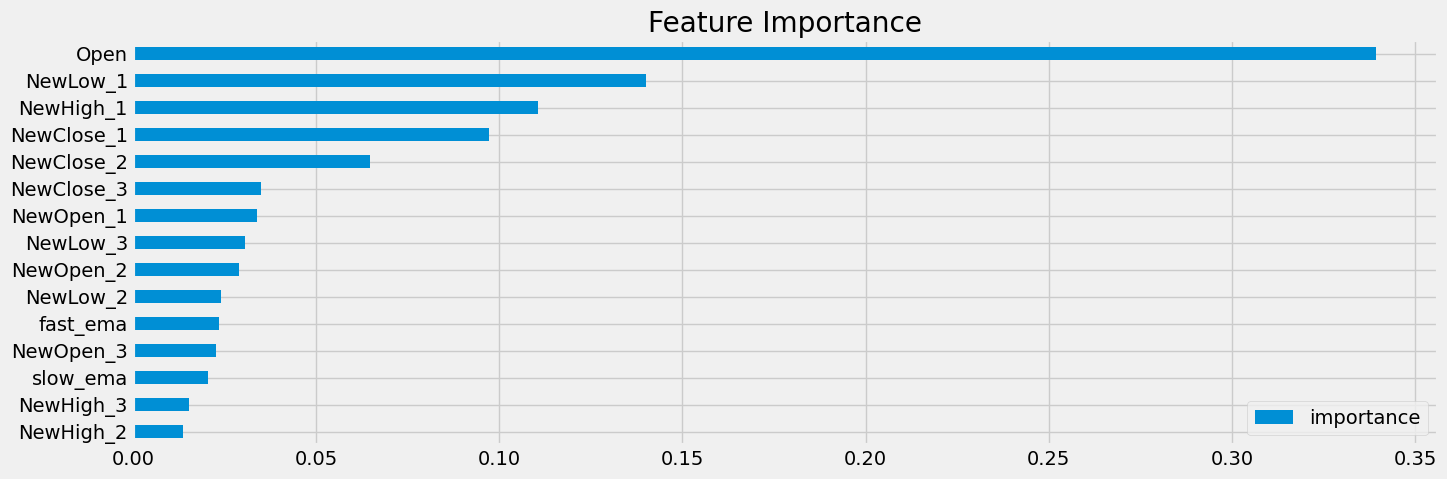

In [110]:
fi = pd.DataFrame(data=reg.feature_importances_,
             columns=['importance'],index=[param for param in signals if param != "Close" ])
fi.sort_values('importance').plot.barh(title='Feature Importance')

plt.show()

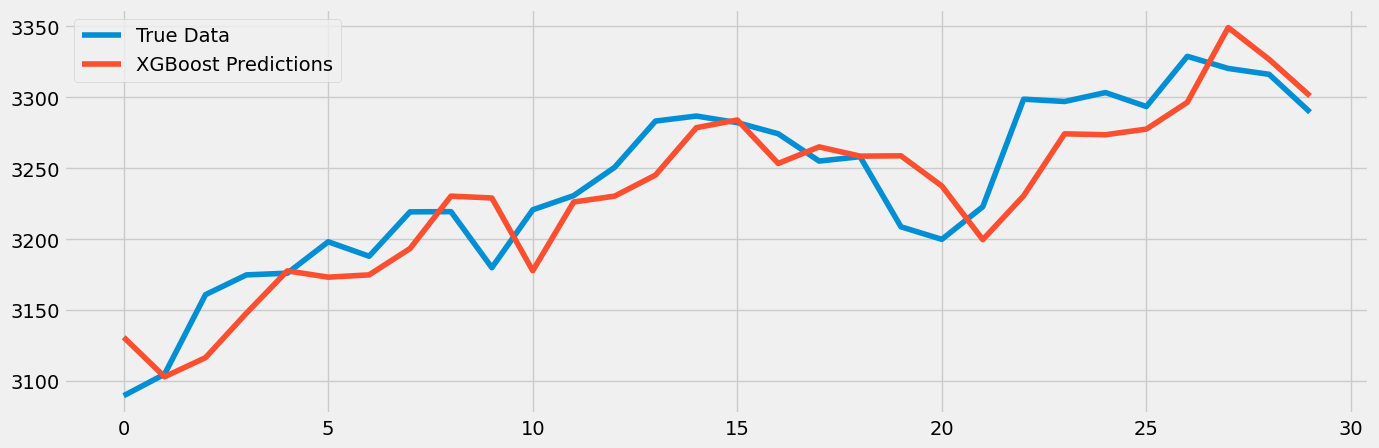

In [119]:
xgpred = reg.predict(X_test)
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(y_test,label='True Data')
plt.plot(xgpred,label='XGBoost Predictions')
plt.legend(loc="upper left")
plt.show()

In [112]:
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()

In [113]:
lin_model.fit(X_train,y_train)

LinearRegression()

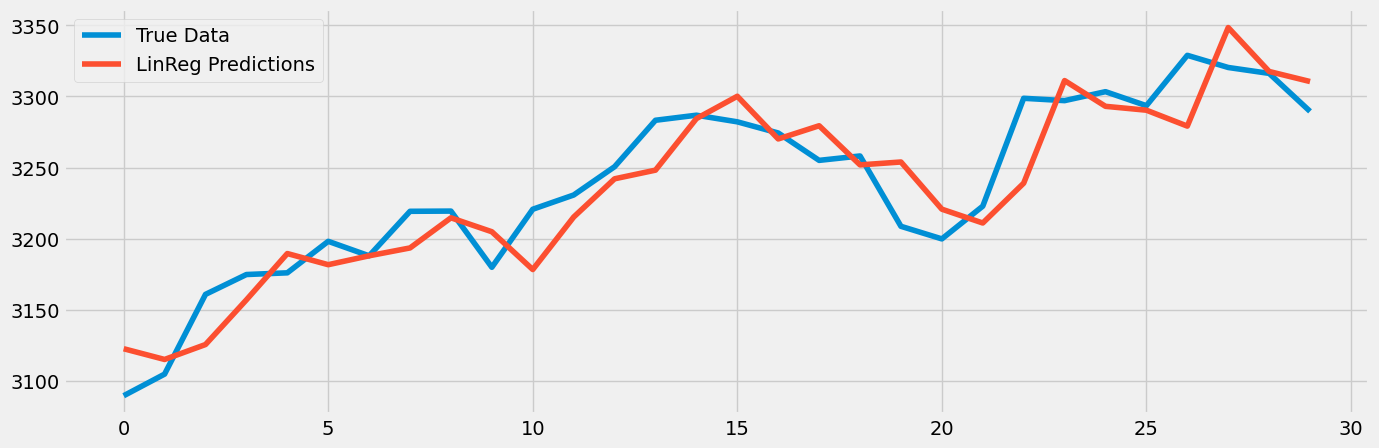

In [114]:
lin_pred=lin_model.predict(X_test)
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(y_test,label='True Data')
plt.plot(lin_pred,label='LinReg Predictions')
plt.legend(loc="upper left")
plt.show()

In [115]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=1000,max_features=10, random_state=1,verbose=True)

In [116]:
model.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


RandomForestRegressor(max_features=10, n_estimators=1000, random_state=1,
                      verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


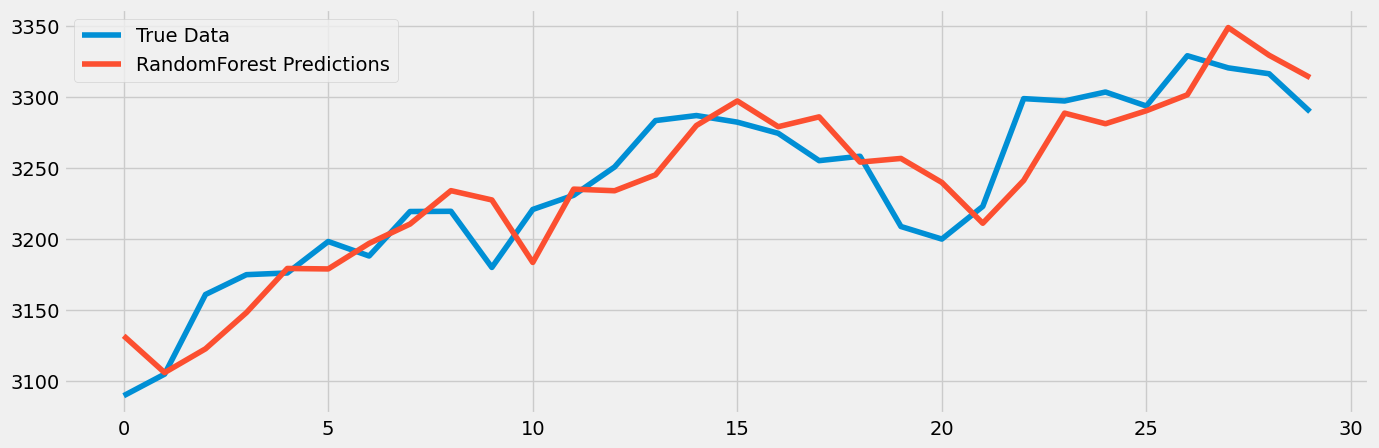

In [117]:
pred=model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(y_test,label='True Data')
plt.plot(pred,label='RandomForest Predictions')
plt.legend(loc="upper left")
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


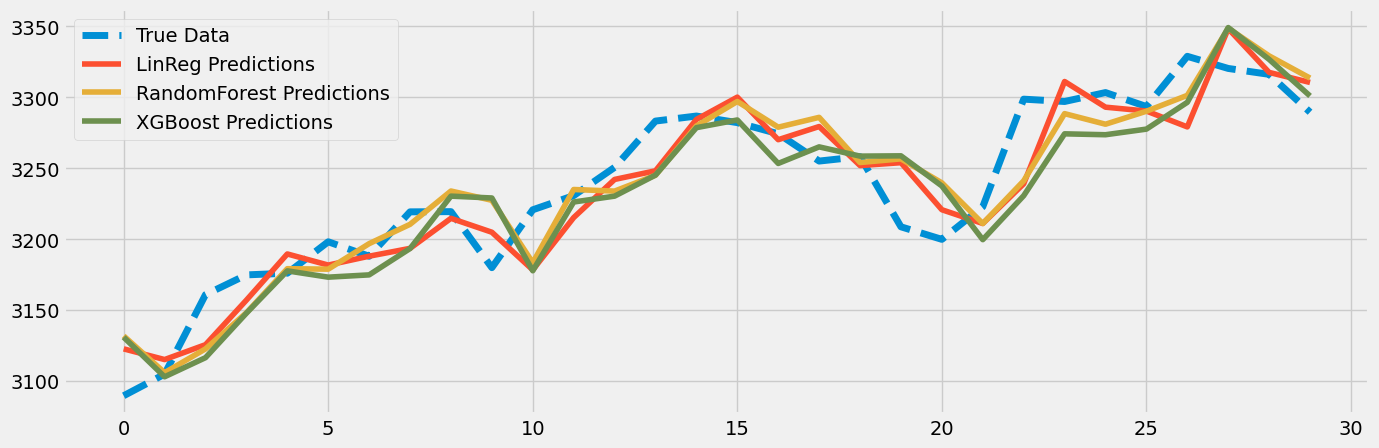

In [120]:
lin_pred=lin_model.predict(X_test)
pred=model.predict(X_test)
xgpred = reg.predict(X_test)
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(y_test,label='True Data',linestyle='--',linewidth=5)
plt.plot(lin_pred,label='LinReg Predictions')
plt.plot(pred,label='RandomForest Predictions')
plt.plot(xgpred,label='XGBoost Predictions')
plt.legend(loc="upper left")
plt.show()


In [24]:
df.tail()

,Date,High,Low,Open,Close,NewOpen_1,NewOpen_2,NewOpen_3,NewClose_1,NewClose_2,...,NewHigh_1,NewHigh_2,NewHigh_3,NewLow_1,NewLow_2,NewLow_3,fast_ema,slow_ema,macd,signal
243,2023-05-25,3306.00,3267.10,3294.0,3293.50,3276.0,3306.0,3230.0,3303.35,3297.05,...,3317.20,3327.95,3308.45,3276.00,3290.1,3217.05,3264.364356,3244.670486,19.693870,13.544948
244,2023-05-26,3338.65,3291.00,3293.5,3328.90,3294.0,3276.0,3306.0,3293.50,3303.35,...,3306.00,3317.20,3327.95,3267.10,3276.0,3290.10,3274.292917,3250.909709,23.383208,15.512600
245,2023-05-29,3372.00,3312.00,3360.8,3320.35,3293.5,3294.0,3276.0,3328.90,3293.50,...,3338.65,3306.00,3317.20,3291.00,3267.1,3276.00,3281.378622,3256.053434,25.325188,17.475117
246,2023-05-30,3326.95,3301.35,3315.0,3316.20,3360.8,3293.5,3294.0,3320.35,3328.90,...,3372.00,3338.65,3306.00,3312.00,3291.0,3267.10,3286.735757,3260.508735,26.227022,19.225498
247,2023-05-31,3327.70,3265.15,3309.0,3289.50,3315.0,3360.8,3293.5,3316.20,3320.35,...,3326.95,3372.00,3338.65,3301.35,3312.0,3291.00,3287.161025,3262.656237,24.504789,20.281356


In [25]:
yesterday = df.tail(1)
today = pd.DataFrame(yesterday[signals])

def neg_make_data(df,name,n):
    for i in range(n-1,0,-1):
        df[f"{name}_{i+1}"] = df[f"{name}_{i}"]
    return df

neg_make_data(today,"NewOpen",3)
neg_make_data(today,"NewHigh",3)
neg_make_data(today,"NewLow",3)
today["NewOpen_1"] = today["Open"]
today["Open"] = float(input("Enter the today's Open "))
today

Enter the today's Open 3314


,Open,NewOpen_1,NewOpen_2,NewOpen_3,NewClose_1,NewClose_2,NewClose_3,NewHigh_1,NewHigh_2,NewHigh_3,NewLow_1,NewLow_2,NewLow_3,fast_ema,slow_ema
247,3314.0,3309.0,3315.0,3360.8,3316.2,3320.35,3328.9,3326.95,3326.95,3372.0,3301.35,3301.35,3312.0,3287.161025,3262.656237


In [26]:
reg.predict(today),lin_model.predict(today),model.predict(today)

/home/matter/.local/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/home/matter/.local/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


(array([3334.5972], dtype=float32),
 array([[3300.0782648]]),
 array([3323.49975]))

<Axes: >

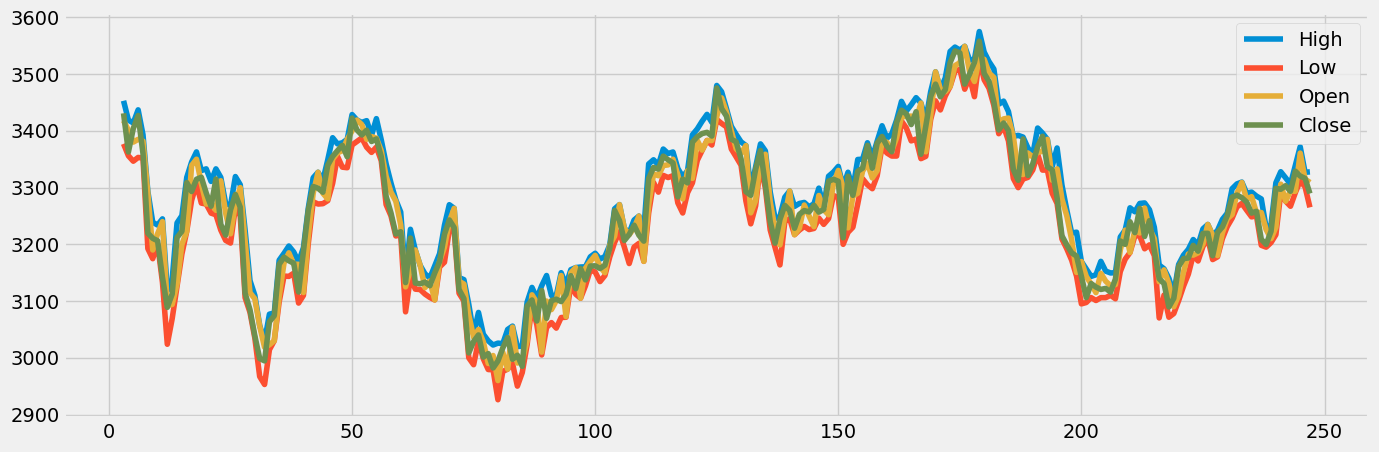

In [32]:
df[['High', 'Low', 'Open', 'Close']].plot()
# df.columns